In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
words=open('names.txt','r').read().splitlines()

In [14]:
words[:1]

['Aamir']

In [15]:
#Data Cleaning
words=[w.replace(' ','' )for w in words]
words=[w.replace('-','' )for w in words]
words=[w.replace("'","" )for w in words]
words=[w.lower() for w in words]

    

In [16]:
len(words)

7945

In [17]:
#Building the vocabulary
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [18]:
#Build the Dataset
block_size=3

def build_dataset(words):
    X,Y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(15)
random.shuffle(words)
n1 = int(0.8*(len(words)))
n2  =int(0.9*(len(words)))

Xtr , Ytr= build_dataset(words[:n1])
Xdev , Ydev= build_dataset(words[n1:n2])  
Xte , Yte = build_dataset(words[:n2])


torch.Size([44616, 3]) torch.Size([44616])
torch.Size([5552, 3]) torch.Size([5552])
torch.Size([50168, 3]) torch.Size([50168])


In [22]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 



parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
 
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 27.7602
  10000/ 200000: 2.5366
  20000/ 200000: 2.0055
  30000/ 200000: 2.1257
  40000/ 200000: 2.3761
  50000/ 200000: 2.2394
  60000/ 200000: 2.2667
  70000/ 200000: 1.6719
  80000/ 200000: 1.8554
  90000/ 200000: 1.5129
 100000/ 200000: 1.5291
 110000/ 200000: 1.7275
 120000/ 200000: 1.5754
 130000/ 200000: 1.9014
 140000/ 200000: 1.2820
 150000/ 200000: 1.5688
 160000/ 200000: 1.8541
 170000/ 200000: 1.9805
 180000/ 200000: 1.5365
 190000/ 200000: 1.7902


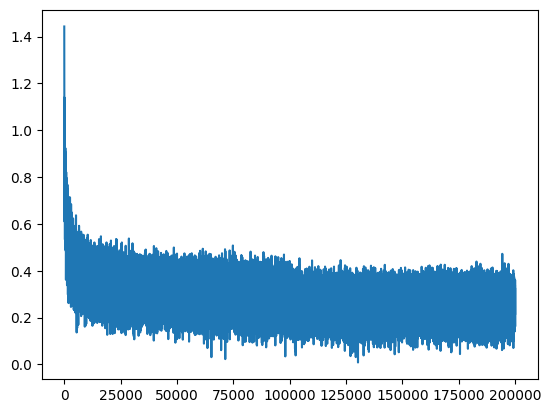

In [24]:
plt.plot(lossi)

In [26]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.1720311641693115
val 2.395601272583008


In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmaina.
belle.
florriz.
taty.
siles.
kerrycita.
meliari.
karlie.
elkaratcheili.
kale.
gabh.
marica.
quint.
salisai.
jaci.
corathro.
jarvie.
fradisi.
sai.
emie.


## Initialization of weights optimised

In [60]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.2 #squashing weights for tanh
b1 = torch.randn(n_hidden,                        generator=g) *0.01 #tanh gets closer to zero value
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) *0  # all logits get zero bias in starting



parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [61]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
 
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 100 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
  

      0/   2000: 3.3148


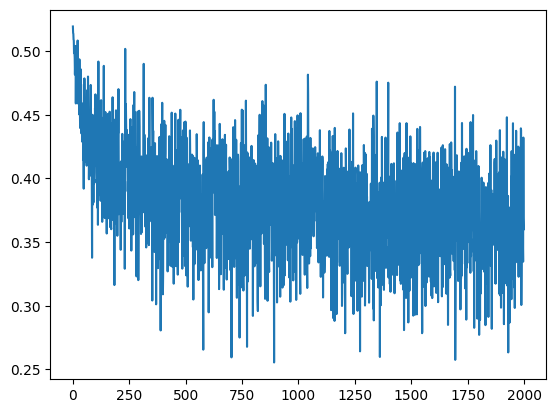

In [54]:
plt.plot(lossi)

In [55]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
#similar results after trained 1/100 steps(times)

train 2.318896770477295
val 2.3361310958862305


In [34]:
logits[0]

tensor([-0.1069, -0.0800, -0.0733,  0.1002,  0.0097, -0.0237,  0.0465,  0.1050,
        -0.1012, -0.1859, -0.0538,  0.3196,  0.2716, -0.0143,  0.0258, -0.1128,
         0.0491,  0.1185, -0.0740,  0.0175, -0.1601, -0.1457,  0.0801,  0.0633,
         0.1143, -0.1436,  0.0925], grad_fn=<SelectBackward0>)

(array([2184.,  137.,  104.,   81.,   43.,   55.,   43.,   34.,   29.,
          33.,   29.,   26.,   25.,   29.,   26.,   16.,   25.,   24.,
          13.,   25.,   13.,   17.,   16.,   18.,   17.,   26.,   25.,
          17.,   18.,   29.,   13.,   25.,   23.,   16.,   29.,   20.,
          31.,   20.,   28.,   36.,   35.,   30.,   37.,   37.,   47.,
          67.,   64.,   92.,  146., 2427.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

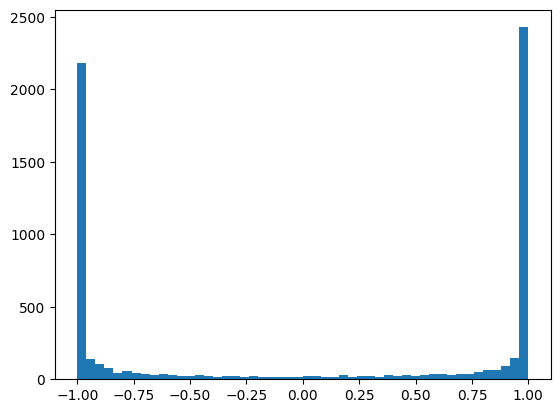

In [43]:
plt.hist(h.view(-1).tolist(),50)

(array([150., 154., 189., 160., 159., 144., 157., 122., 121., 132., 118.,
        101., 136.,  98.,  92., 109.,  91., 123., 119., 119.,  97.,  86.,
        108.,  71., 114., 100., 101., 118.,  94., 106.,  93., 120.,  90.,
        132.,  92., 130., 109., 108., 112., 113., 104., 136., 147., 166.,
        184., 156., 183., 203., 217., 216.]),
 array([-9.99542177e-01, -9.59558384e-01, -9.19574592e-01, -8.79590800e-01,
        -8.39607008e-01, -7.99623215e-01, -7.59639423e-01, -7.19655631e-01,
        -6.79671838e-01, -6.39688046e-01, -5.99704254e-01, -5.59720461e-01,
        -5.19736669e-01, -4.79752877e-01, -4.39769084e-01, -3.99785292e-01,
        -3.59801500e-01, -3.19817708e-01, -2.79833915e-01, -2.39850123e-01,
        -1.99866331e-01, -1.59882538e-01, -1.19898746e-01, -7.99149537e-02,
        -3.99311614e-02,  5.26309013e-05,  4.00364232e-02,  8.00202155e-02,
         1.20004008e-01,  1.59987800e-01,  1.99971592e-01,  2.39955385e-01,
         2.79939177e-01,  3.19922969e-01,  3.59906

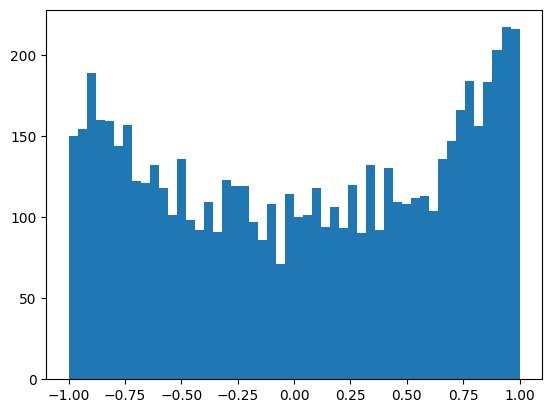

In [62]:
plt.hist(h.view(-1).tolist(),50) #new tanh values

In [67]:
(torch.randn(10000)*0.2).std()

tensor(0.2000)

In [68]:
n_embd * block_size

30

In [70]:
#multiply weight with std= gain/fan_mode**0.5 
(5/3)/(30**0.5)

0.3042903097250923

In [71]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ ((n_embd * block_size)**0.5 )          # *0.2 #squashing weights for tanh
b1 = torch.randn(n_hidden,                        generator=g) *0.01 #tanh gets closer to zero value
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) *0  # all logits get zero bias in starting



parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [72]:
# same optimization as last time
max_steps = 2000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
 
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 100 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/   2000: 3.3196


## Batch Normalisation

In [73]:
#in batch normalization just normalise the values before inserting into activation function(here tanh)

In [74]:
hpreact.shape

torch.Size([32, 200])

In [77]:
hpreact.mean(dim=0,keepdims=True).shape

torch.Size([1, 200])

In [78]:
hpreact.std(dim=0,keepdims=True).shape

torch.Size([1, 200])

In [93]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ ((n_embd * block_size)**0.5 )          # *0.2 #squashing weights for tanh
#b1 = torch.randn(n_hidden,                        generator=g) *0.01 #tanh gets closer to zero value
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) *0  # all logits get zero bias in starting

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [98]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(dim=0,keepdims=True)
  bnstdi = hpreact.std(dim=0,keepdims=True)
  hpreact = bngain*(hpreact- hpreact.mean(dim=0,keepdims=True))/hpreact.std(dim=0,keepdims=True)+bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/  20000: 3.2900
   1000/  20000: 2.6011
   2000/  20000: 2.1491
   3000/  20000: 2.6553
   4000/  20000: 2.4039
   5000/  20000: 2.1074
   6000/  20000: 2.1076
   7000/  20000: 2.2644
   8000/  20000: 2.0372
   9000/  20000: 1.9653
  10000/  20000: 2.6296
  11000/  20000: 2.2736
  12000/  20000: 2.2329
  13000/  20000: 2.3222
  14000/  20000: 2.0337
  15000/  20000: 2.0741
  16000/  20000: 1.9369
  17000/  20000: 1.8843
  18000/  20000: 2.3850
  19000/  20000: 1.9779


In [99]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [100]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain*(hpreact- bnmean)/ bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.041127920150757
val 2.1296145915985107


loss log
original:
train 2.1245384216308594 val 2.168196439743042

fix softmax confidently wrong:
train 2.07 val 2.13

fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

add batch norm layer
train 2.0668270587921143 val 2.104844808578491

## Torchifying The Code

In [113]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out= x @ self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum = momentum
        self.training =True
        #parameters (trained with bachpropagation)
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean=x.mean(0,keepdims=True)
            xvar=x.var(0,keepdims=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        xhat=(x-xmean)/torch.sqrt(xvar+ self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
             with torch.no_grad():
                 self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                 self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(15) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
        

47024


In [114]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  

      0/  20000: 3.3162
   1000/  20000: 2.4461
   2000/  20000: 2.4239
   3000/  20000: 2.3836
   4000/  20000: 2.0533
   5000/  20000: 2.2864
   6000/  20000: 2.0144
   7000/  20000: 1.9270
   8000/  20000: 2.1541
   9000/  20000: 2.1542
  10000/  20000: 1.9336
  11000/  20000: 2.3705
  12000/  20000: 2.0581
  13000/  20000: 2.1663
  14000/  20000: 1.9181
  15000/  20000: 2.1692
  16000/  20000: 1.8071
  17000/  20000: 2.2701
  18000/  20000: 2.2061
  19000/  20000: 1.8828


layer 2 (      Tanh): mean -0.00, std 0.65, saturated: 8.75%
layer 5 (      Tanh): mean -0.01, std 0.67, saturated: 9.91%
layer 8 (      Tanh): mean +0.01, std 0.69, saturated: 9.78%
layer 11 (      Tanh): mean +0.00, std 0.71, saturated: 7.66%
layer 14 (      Tanh): mean -0.02, std 0.74, saturated: 5.75%


C:\Users\rsdha\AppData\Local\Temp\ipykernel_19672\1397477801.py:7: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

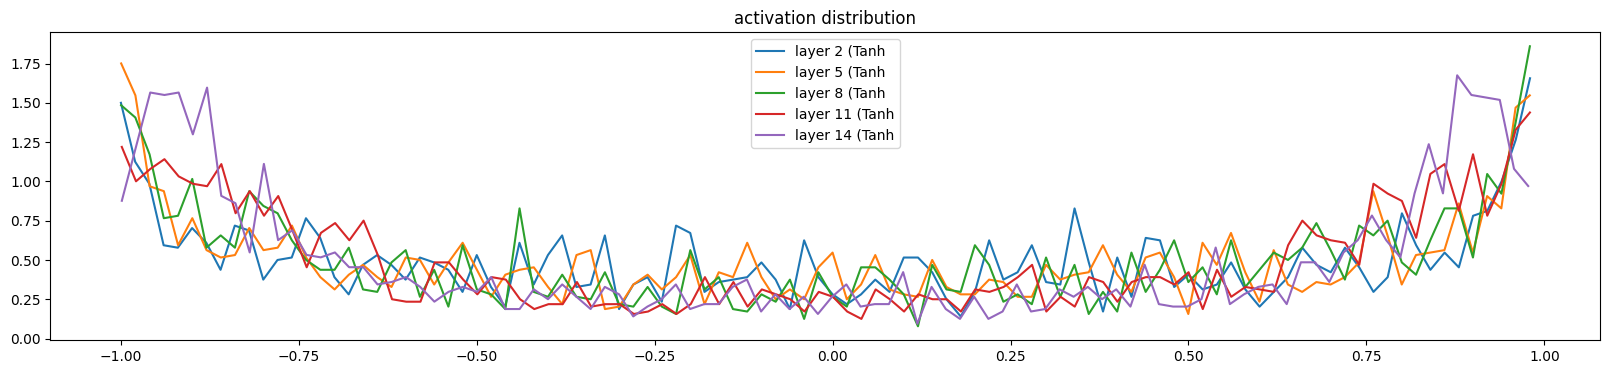

In [115]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 5.108549e-03
layer 5 (      Tanh): mean +0.000000, std 4.567812e-03
layer 8 (      Tanh): mean -0.000000, std 4.159050e-03
layer 11 (      Tanh): mean +0.000000, std 4.066286e-03
layer 14 (      Tanh): mean -0.000000, std 4.389210e-03


Text(0.5, 1.0, 'gradient distribution')

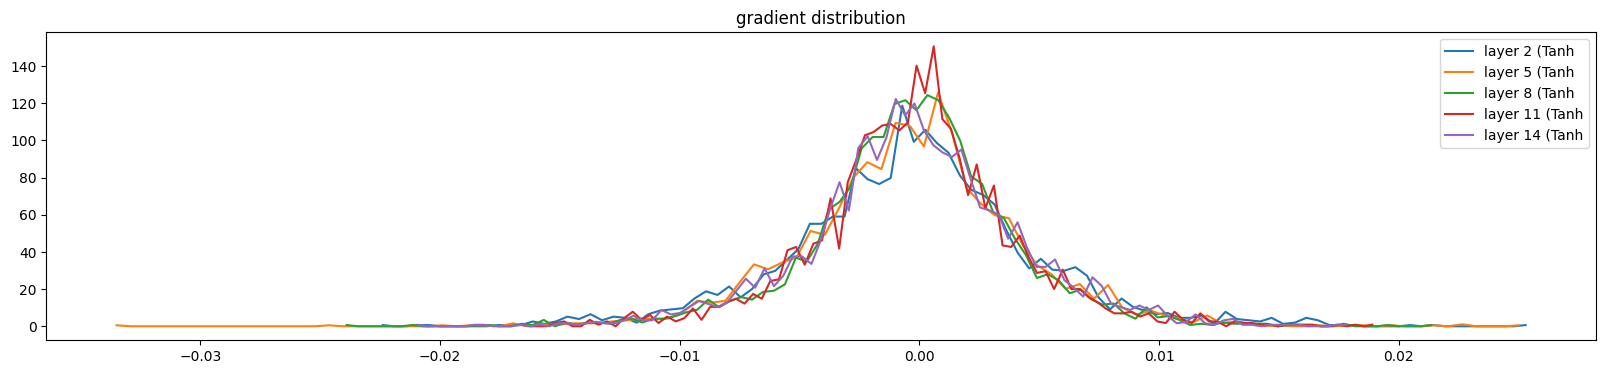

In [116]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.856931e-02 | grad:data ratio 1.766569e-02
weight  (30, 100) | mean -0.000043 | std 1.142776e-02 | grad:data ratio 3.360274e-02
weight (100, 100) | mean -0.000035 | std 7.774736e-03 | grad:data ratio 3.947295e-02
weight (100, 100) | mean +0.000122 | std 7.420303e-03 | grad:data ratio 3.791751e-02
weight (100, 100) | mean +0.000021 | std 6.907970e-03 | grad:data ratio 3.591734e-02
weight (100, 100) | mean -0.000050 | std 6.543566e-03 | grad:data ratio 3.483376e-02
weight  (100, 27) | mean +0.000041 | std 1.298102e-02 | grad:data ratio 5.467885e-02


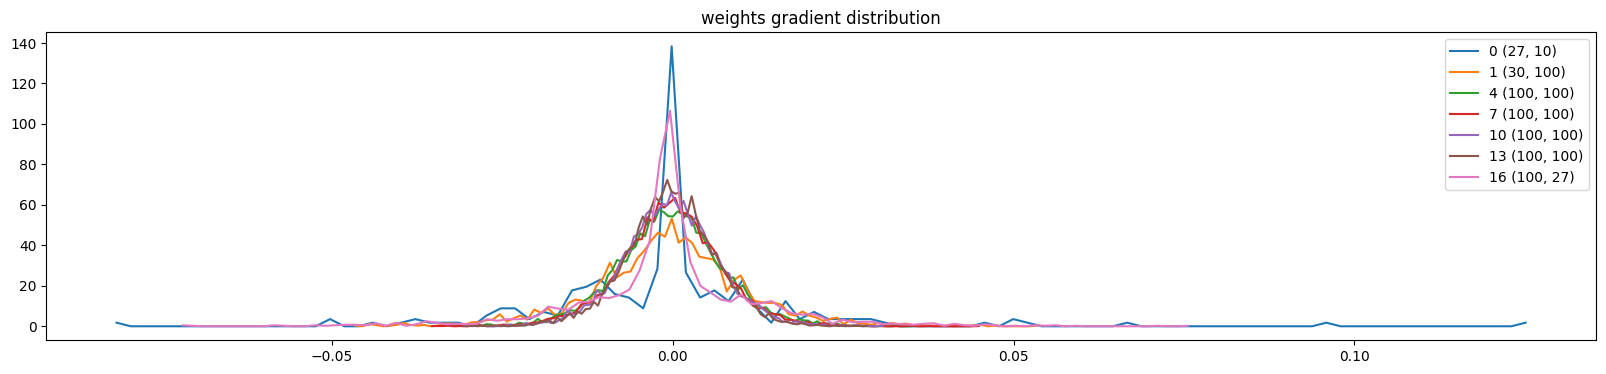

In [117]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

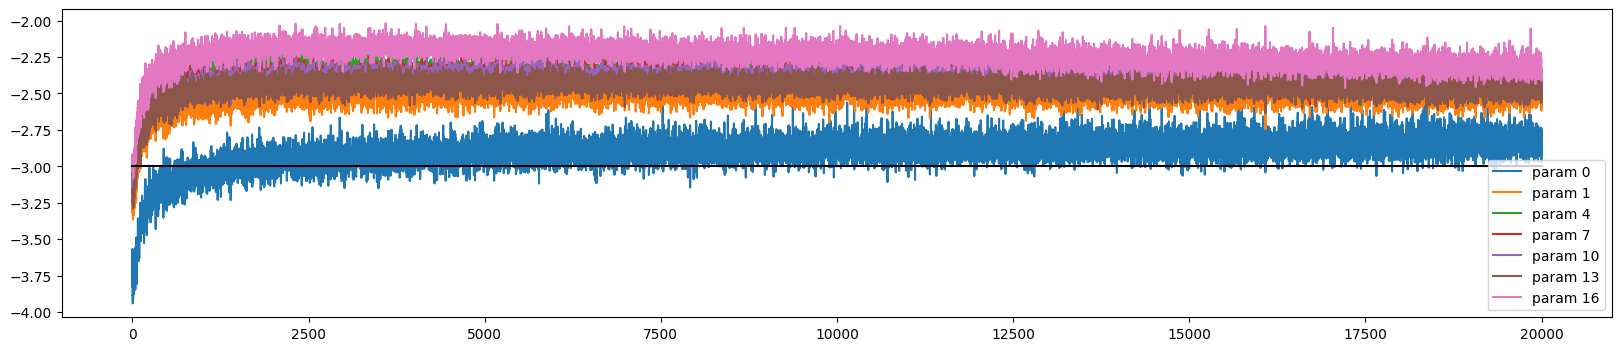

In [118]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [119]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9579188823699951
val 2.08500075340271


## Sampling From the Model

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmaifaurill.
lin.
mris.
thollina.
stace.
zonee.
dellyn.
parqui.
neronia.
christin.
leigh.
ham.
pois.
quintharline.
live.
quinte.
patiaruxi.
frances.
sabell.
edi.
